# 0. Imports

In [1]:
from pipeline.load_activations import prepare_dataloaders
import torch
import torch.nn as nn
import gc
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from einops import einsum

## 1. Progress bar trajectories

In [2]:
train_dataloader, test_dataloader, stats = prepare_dataloaders(
        activations_dir="/workspace/rollouts-big/activations",
        batch_size=1024,
        test_size=0.2,
        end_idx = 2000,
        shuffle = True
    )

2025-10-06 22:20:36,497 - INFO - Loading activations from: /workspace/rollouts-big/activations
2025-10-06 22:20:36,498 - INFO - Loading activations from index 0 to 2000
2025-10-06 22:20:38,029 - INFO - Loaded 100 activations
2025-10-06 22:20:39,331 - INFO - Loaded 200 activations
2025-10-06 22:20:40,861 - INFO - Loaded 300 activations
2025-10-06 22:20:42,262 - INFO - Loaded 400 activations
2025-10-06 22:20:43,924 - INFO - Loaded 500 activations
2025-10-06 22:20:45,427 - INFO - Loaded 600 activations
2025-10-06 22:20:46,959 - INFO - Loaded 700 activations
2025-10-06 22:20:48,467 - INFO - Loaded 800 activations
2025-10-06 22:20:50,053 - INFO - Loaded 900 activations
2025-10-06 22:20:51,476 - INFO - Loaded 1000 activations
2025-10-06 22:20:53,079 - INFO - Loaded 1100 activations
2025-10-06 22:20:54,693 - INFO - Loaded 1200 activations
2025-10-06 22:20:56,896 - INFO - Loaded 1300 activations
2025-10-06 22:21:00,333 - INFO - Loaded 1400 activations
2025-10-06 22:21:02,480 - INFO - Loaded 15

### linear to predict linear

In [3]:
all_acts = []
all_n_remaining = []

In [4]:
for activations, n_remaining, n_total in train_dataloader:
    all_acts.append(activations.to('cuda', dtype=torch.float32))
    all_n_remaining.append(n_remaining.to('cuda', dtype=torch.float32))

all_acts = torch.cat(all_acts)
all_n_remaining = torch.cat(all_n_remaining)


In [ ]:
all_acts = all_acts

torch.Size([1403562, 2560])

In [9]:
all_acts.isnan().sum()

tensor(0, device='cuda:0')

In [10]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ all_n_remaining
linear_to_linear_betas = torch.linalg.solve(XTX, XTy)

In [11]:
linear_to_linear_betas.shape

torch.Size([2560])

In [12]:
torch.save(linear_to_linear_betas, '/workspace/final_write_up/linear_to_linear_betas.pt')

### linear to predict log

In [13]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ (all_n_remaining + 1).log()
linear_to_log_betas = torch.linalg.solve(XTX, XTy)
torch.save(linear_to_log_betas, '/workspace/final_write_up/linear_to_log_betas.pt')

In [14]:
del all_acts, all_n_remaining, linear_to_linear_betas, linear_to_log_betas

gc.collect()
torch.cuda.empty_cache()

### bins classifier

In [15]:
class LogBinClassifer(nn.Module):
    def __init__(self, input_dim: int, n_bins: int):
        super().__init__()
        self.n_bins = n_bins
        self.linear = nn.Linear(input_dim, n_bins)

    def forward(self, x):
        return self.linear(x)

In [20]:
model = LogBinClassifer(2560, 10).to('cuda')
optimizer = Adam(model.parameters(), lr=1e-4)

In [21]:
loss_fn = CrossEntropyLoss()

In [22]:
n_bins = 11
def bin_y(y):
    return (y+1).log().floor().clamp(0,n_bins-1).to('cuda', dtype=torch.long)

In [ ]:
n_epochs = 3
for epoch in range(n_epochs):
    for activations, n_remaining, n_total in train_dataloader:
        optimizer.zero_grad()
        pred = model(activations.to('cuda', dtype=torch.float32))
        n_remaining_binned = bin_y(n_remaining)
        loss = loss_fn(pred, n_remaining_binned)
        loss.backward()
        optimizer.step()
        print(loss.item())
        

2.239861011505127
2.206599712371826
2.208305835723877
2.1977295875549316
2.1513068675994873
2.1231656074523926
2.1272852420806885
2.1199147701263428
2.0752995014190674
2.0763330459594727
2.080860137939453
2.082491159439087
2.058995008468628
2.021541118621826
2.0057213306427
1.99550461769104
1.9898747205734253
1.9720473289489746
1.9653269052505493
1.9730620384216309
1.9700201749801636
1.9314427375793457
1.9483355283737183
1.9652069807052612
1.90811026096344
1.8886442184448242
1.8819682598114014
1.8798828125
1.878554344177246
1.8440275192260742
1.8424221277236938
1.8442695140838623
1.8657467365264893
1.8458096981048584
1.8073556423187256
1.8213996887207031
1.811496615409851
1.8013811111450195
1.7739038467407227
1.7955113649368286
1.7634837627410889
1.7658519744873047
1.7561323642730713
1.7627129554748535
1.772189736366272
1.7743489742279053
1.7618129253387451
1.7019442319869995
1.7342498302459717
1.7221261262893677
1.7343058586120605
1.750671625137329
1.7456121444702148
1.714626431465149

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), '/workspace/final_write_up/log_bin_classifier.pt')

### using the randomly sampled from each sequence

### eval on test prompts

In [30]:
def sequence_to_pred_n_remaining_lin_to_lin(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].clamp(min=0) # s
    return pred_n_remaining

In [72]:
def sequence_to_pred_n_remaining_lin_to_log(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].exp() # s
    return pred_n_remaining

In [73]:
def sequence_to_pred_n_remaining_classifier(sequence: torch.Tensor, classifier: nn.Module) -> torch.Tensor:
    logits = classifier(sequence[0].to('cuda', dtype=torch.float32))
    probs = torch.softmax(logits, dim=1)
    n_bins = probs.shape[1]
    pred_n_remaining = torch.sum(probs * torch.arange(n_bins, device=logits.device), dim=1).exp()
    return pred_n_remaining

In [74]:
def pred_n_remaining_to_percent_estimate(pred_n_remaining: torch.Tensor) -> torch.Tensor:
    token_number = torch.arange(pred_n_remaining.shape[0], device=pred_n_remaining.device) 
    n_remaining_percent = token_number / (token_number + pred_n_remaining)
    return n_remaining_percent


In [75]:
def get_start_pos(token_ids: torch.Tensor) -> int:
    im_start_token = 151644
    im_start_positions = (token_ids == im_start_token).nonzero(as_tuple=True)[0]
    return im_start_positions[1].item()



In [101]:
all_pred_percent_estimates = {'lin_to_lin': [], 'lin_to_log': [], 'log_bin_classifier': []}
all_actual_n_remaining = []
all_log_pred_estimates = {'lin_to_lin': [], 'lin_to_log': [], 'log_bin_classifier': []}
all_log_n_tokens_remaining = []
for i in range(100):
    token_ids, sequence = torch.load(f'/workspace/rollouts-big/test/activations/{i}.pt')
    sequence = sequence.to('cuda')
    start_pos = get_start_pos(token_ids)
    sequence = sequence[:, start_pos:]
    actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
    lin_to_lin_betas = torch.load('/workspace/final_write_up/linear_to_linear_betas.pt').to('cuda', dtype = torch.bfloat16)
    lin_to_log_betas = torch.load('/workspace/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
    lin_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_lin(sequence, lin_to_lin_betas)
    log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, lin_to_log_betas)
    classifier_pred_n_remaining = sequence_to_pred_n_remaining_classifier(sequence, model)
    lin_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(lin_pred_n_remaining)
    log_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(log_pred_n_remaining)
    classifier_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(classifier_pred_n_remaining)

    all_pred_percent_estimates['lin_to_lin'].append(lin_pred_n_remaining_percent)
    all_pred_percent_estimates['lin_to_log'].append(log_pred_n_remaining_percent)
    all_pred_percent_estimates['log_bin_classifier'].append(classifier_pred_n_remaining_percent)

    all_log_pred_estimates['lin_to_lin'].append((lin_pred_n_remaining + 1).log())
    all_log_pred_estimates['lin_to_log'].append((log_pred_n_remaining + 1).log())
    all_log_pred_estimates['log_bin_classifier'].append((classifier_pred_n_remaining + 1).log())

    all_actual_n_remaining.append(actual_n_remaining)
    all_log_n_tokens_remaining.append((actual_n_remaining + 1).log())
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [102]:
import matplotlib.pyplot as plt

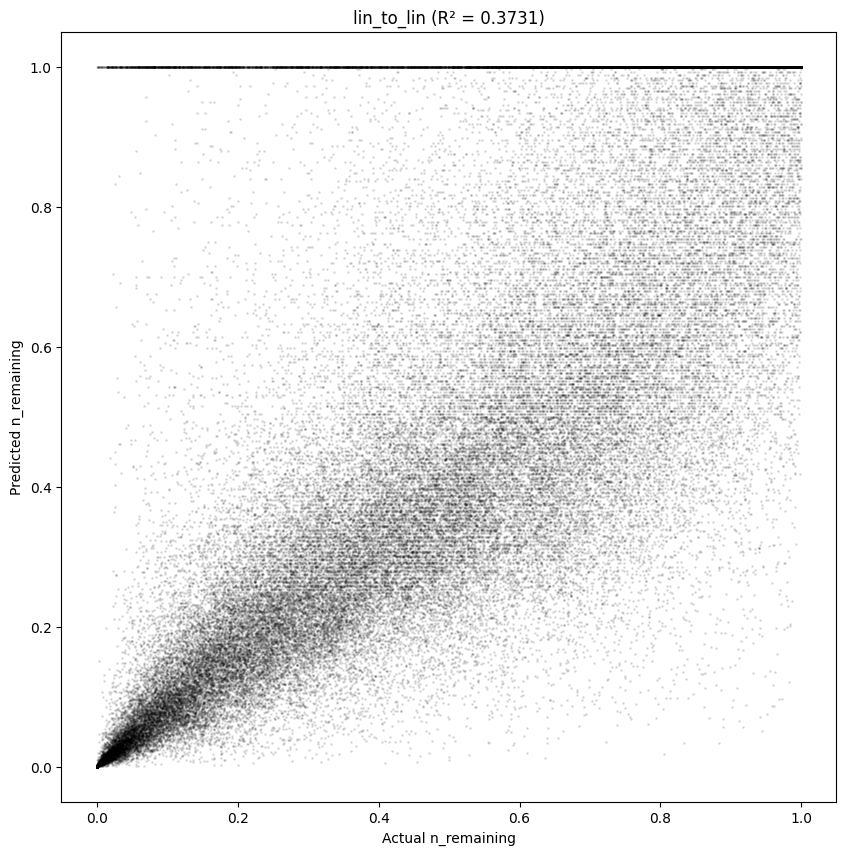

<Figure size 640x480 with 0 Axes>

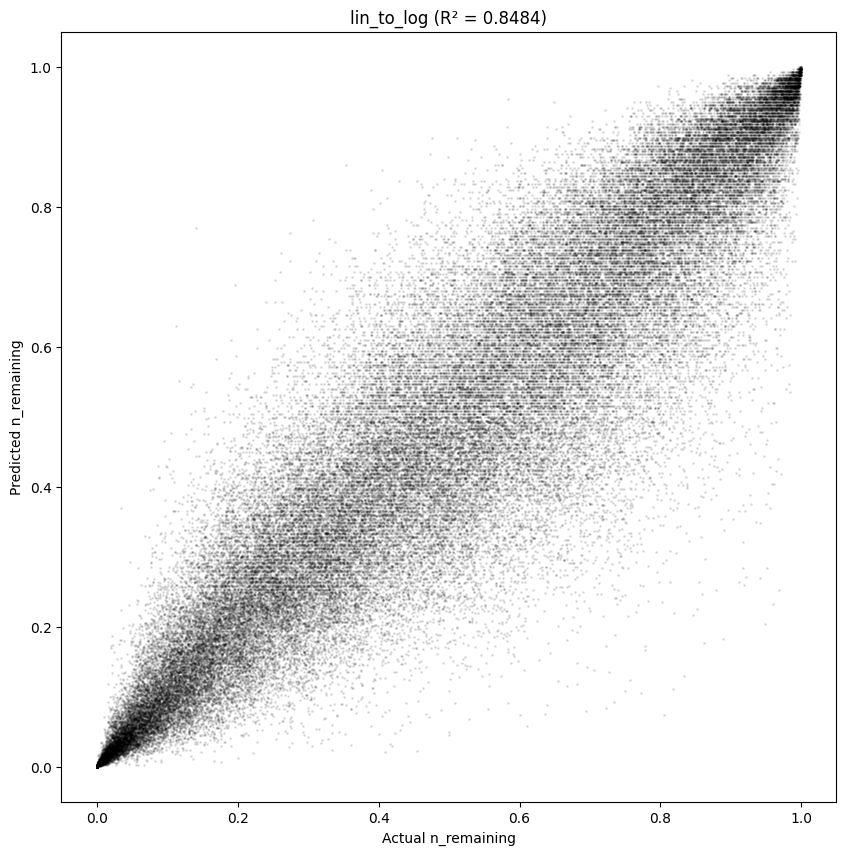

<Figure size 640x480 with 0 Axes>

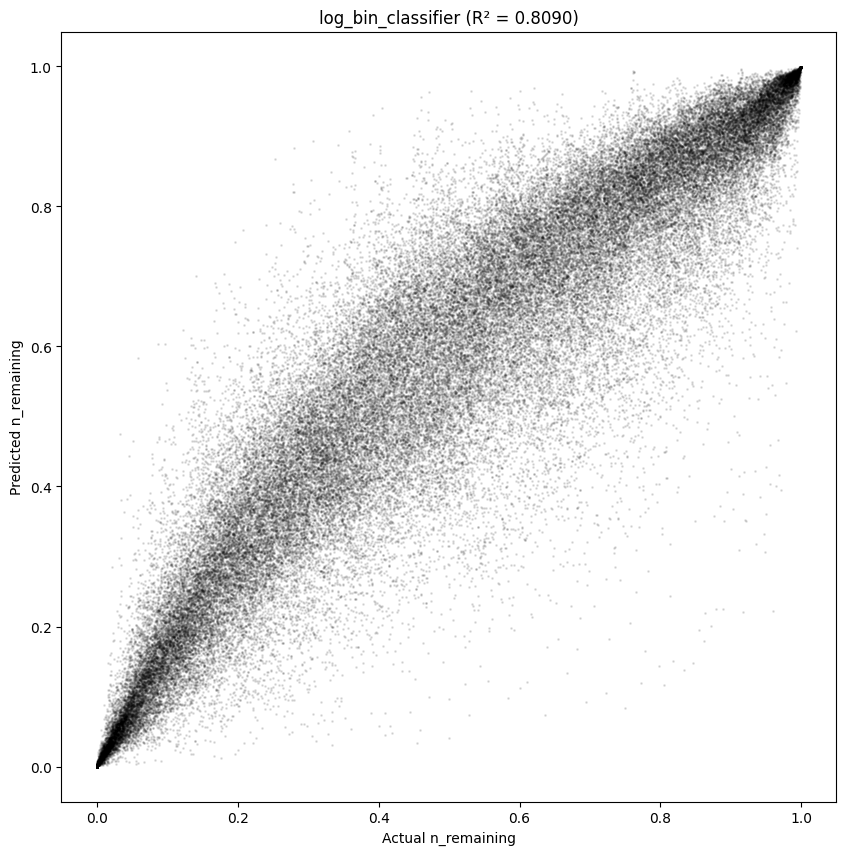

<Figure size 640x480 with 0 Axes>

In [103]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_pred_percent_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_pred_percent_estimates[model_type])):
        actual = 1-(all_actual_n_remaining[i]/len(all_actual_n_remaining[i])).float().detach().cpu().numpy()
        predicted = all_pred_percent_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(actual, predicted, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Actual n_remaining')
    plt.ylabel('Predicted n_remaining')
    plt.show()
    
    plt.savefig(f'/workspace/final_write_up/plots/{model_type}.png')


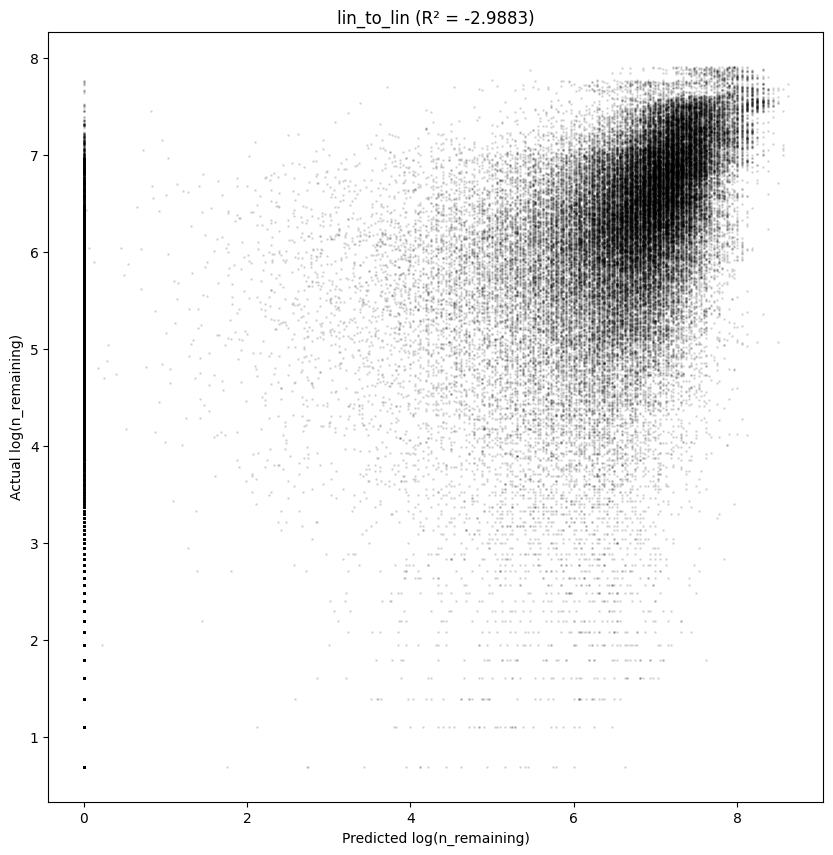

<Figure size 640x480 with 0 Axes>

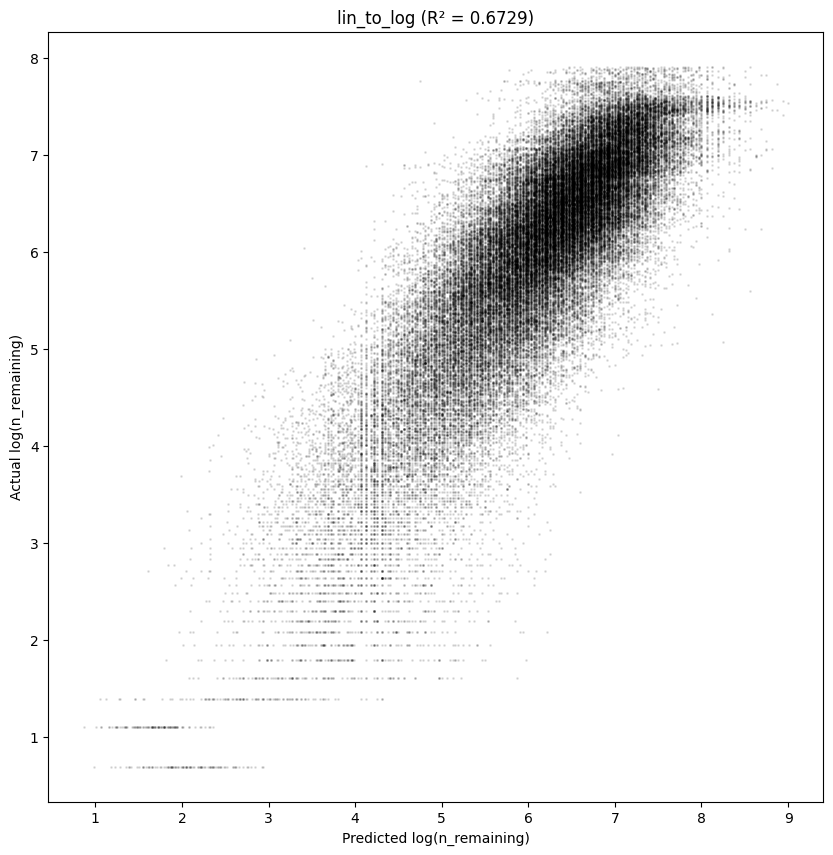

<Figure size 640x480 with 0 Axes>

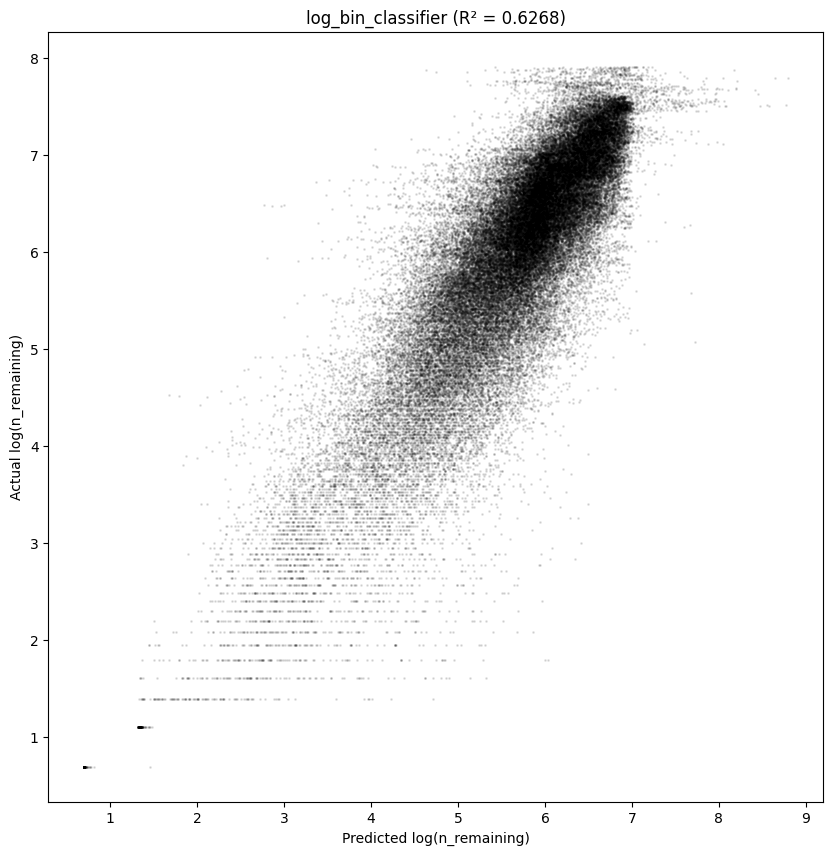

<Figure size 640x480 with 0 Axes>

In [105]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(predicted, actual, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    plt.show()
    
    plt.savefig(f'/workspace/final_write_up/plots/{model_type}_log.png')


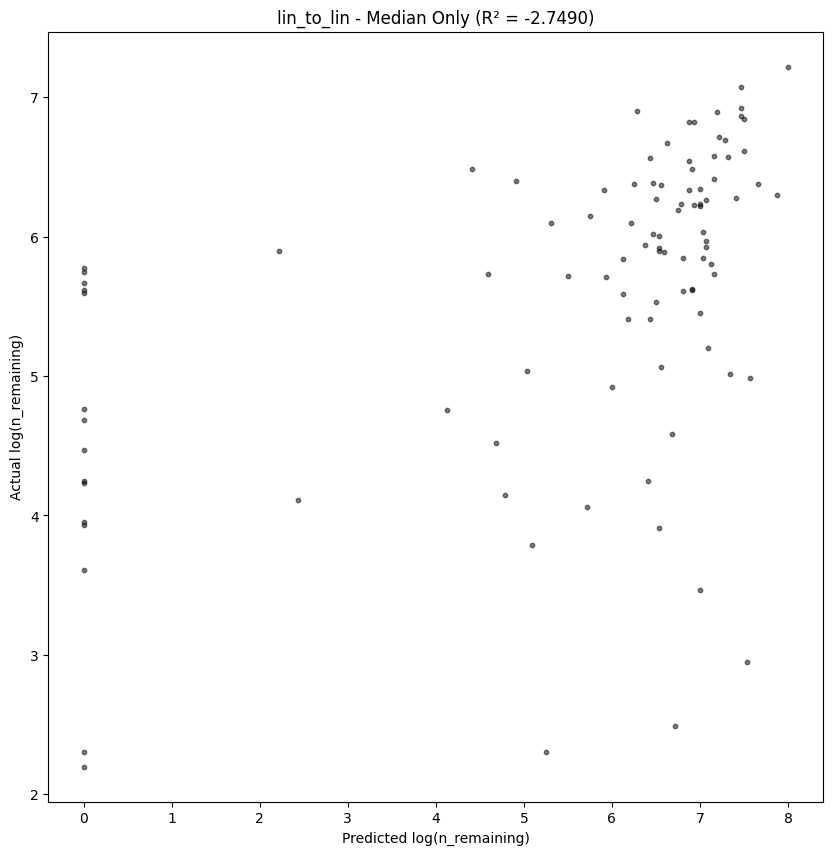

<Figure size 640x480 with 0 Axes>

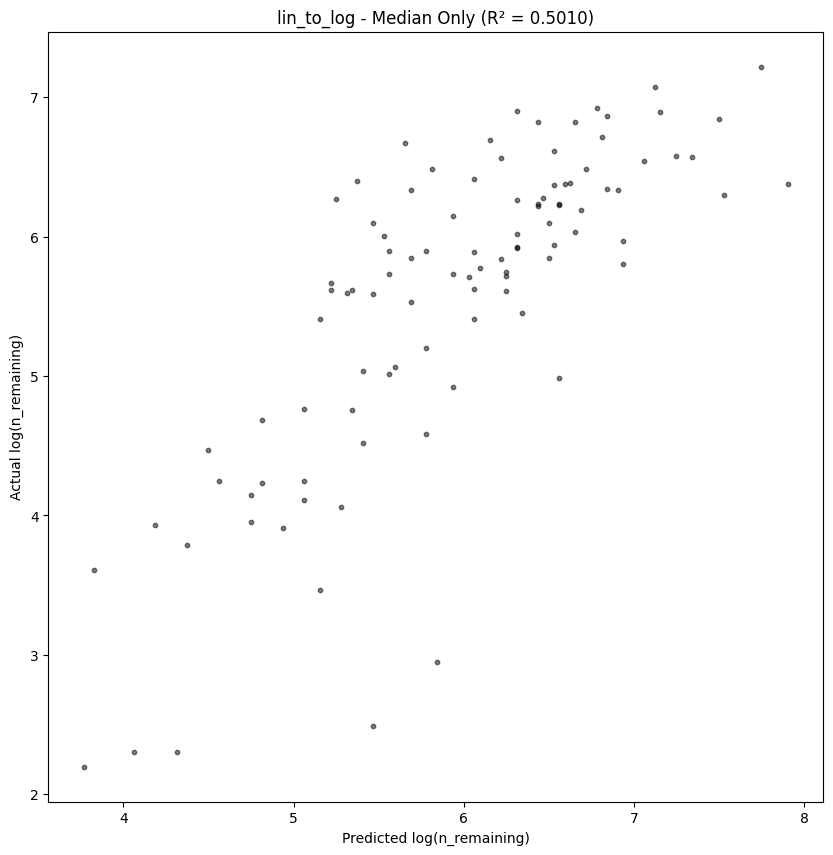

<Figure size 640x480 with 0 Axes>

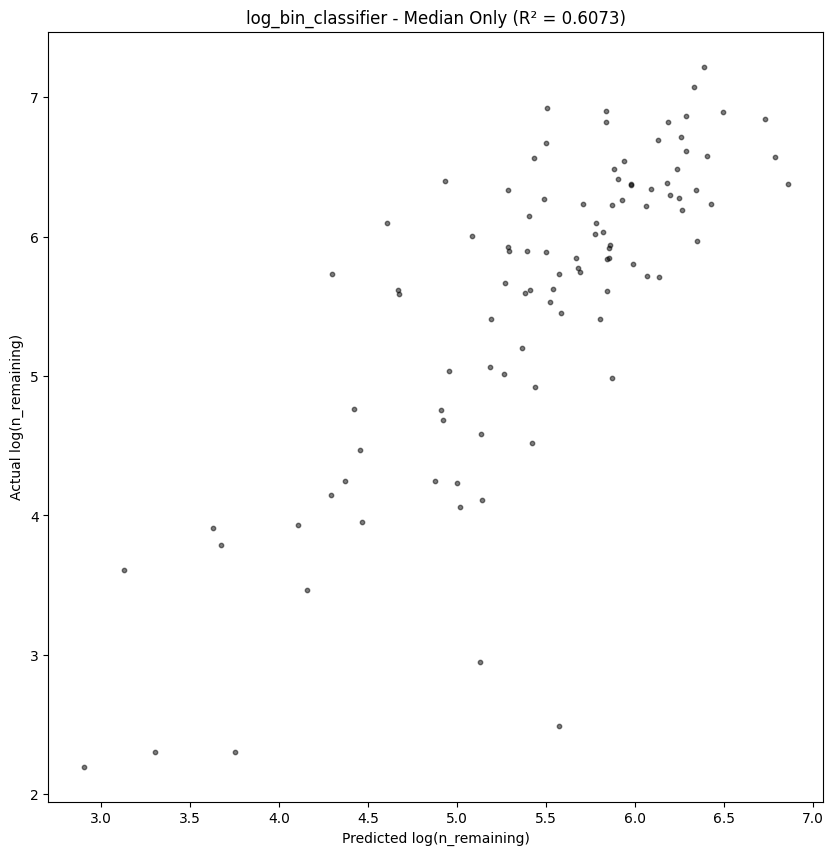

<Figure size 640x480 with 0 Axes>

In [106]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation (median idx only)
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        # Take only the median index for each sequence
        median_idx = len(actual) // 2
        all_actual.append(actual[median_idx])
        all_predicted.append(predicted[median_idx])
        
        plt.scatter(predicted[median_idx], actual[median_idx], alpha=0.5, s=10, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} - Median Only (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    plt.show()
    
    plt.savefig(f'/workspace/final_write_up/plots/{model_type}_log_median.png')


## 2. predicted n_tokens_remaining vs actual R^2 for good and bad data mix (and logistic classifiers on each of these)

## 3. n_tokens before < / think>

## 4. R2 of predicted tokens with EMA = 0.9 and EMA = 0

show here that we do not benefit from more data